In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

f:\ComputerStuff\Anaconda\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#dataset loading, scaling and batching

#from torch.utils.data import Dataset  # Needed for custom Dataset

df = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 1000000)

scaler = MinMaxScaler()
num_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[num_cols] = scaler.fit_transform(df[num_cols])

le_type = LabelEncoder()
le_orig = LabelEncoder()
le_dest = LabelEncoder()

df['type'] = le_type.fit_transform(df['type'])
df['nameOrig'] = le_orig.fit_transform(df['nameOrig'])
df['nameDest'] = le_dest.fit_transform(df['nameDest'])

df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0.0,3,0.000984,119308,0.004369,0.004116,260228,0.000000,0.0,0,0
1,0.0,3,0.000186,344548,0.000546,0.000498,271255,0.000000,0.0,0,0
2,0.0,4,0.000018,157488,0.000005,0.000000,71521,0.000000,0.0,1,0
3,0.0,1,0.000018,917153,0.000005,0.000000,63661,0.000504,0.0,1,0
4,0.0,3,0.001167,541681,0.001067,0.000767,132495,0.000000,0.0,0,0


In [3]:
#class

#class FraudDataset(Dataset):
#    def __init__(self, df):
#        self.num_data = df[num_cols].values.astype('float32')
#        self.type = df['type_enc'].values.astype('int64')
#        self.orig = df['nameOrig_enc'].values.astype('int64')
#        self.dest = df['nameDest_enc'].values.astype('int64')
#        self.labels = df['isFraud'].values.astype('float32')
#
#    def __len__(self):
#        return len(self.labels)
#
#    def __getitem__(self, idx):
#        return {
#            'numerical': torch.tensor(self.num_data[idx]),
#            'type': torch.tensor(self.type[idx]),
#            'nameOrig': torch.tensor(self.orig[idx]),
#            'nameDest': torch.tensor(self.dest[idx]),
#            'label': torch.tensor(self.labels[idx])
#        }



import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, in_features=9, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=out_features)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)

In [4]:

#fraud = df['isFraud']
#df = df.drop(['isFraud', 'isFlaggedFraud'], axis = 1)
#df['isFraud'] = fraud 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

# Select only numeric columns for model input
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=0, pin_memory=True)
    


epoch: 1 -> loss: 0.2364690899848938
epoch: 2 -> loss: 0.23117035627365112
epoch: 3 -> loss: 0.1823940873146057
epoch: 4 -> loss: 0.1578737050294876
epoch: 5 -> loss: 0.19670407474040985
epoch: 6 -> loss: 0.20051991939544678
epoch: 7 -> loss: 0.22167398035526276
epoch: 8 -> loss: 0.264838844537735
epoch: 9 -> loss: 0.1893654316663742
epoch: 10 -> loss: 0.23676066100597382
epoch: 11 -> loss: 0.20864056050777435
epoch: 12 -> loss: 0.18954235315322876
epoch: 13 -> loss: 0.1781708002090454
epoch: 14 -> loss: 0.22587604820728302
epoch: 15 -> loss: 0.21864137053489685
epoch: 16 -> loss: 0.24977323412895203
epoch: 17 -> loss: 0.23144298791885376
epoch: 18 -> loss: 0.2217634916305542
epoch: 19 -> loss: 0.23169267177581787
epoch: 20 -> loss: 0.2173929661512375
epoch: 21 -> loss: 1.3828336000442505
epoch: 22 -> loss: 0.181406170129776
epoch: 23 -> loss: 1.5575510263442993
epoch: 24 -> loss: 0.21796000003814697
epoch: 25 -> loss: 0.2016022950410843
epoch: 26 -> loss: 0.16451843082904816
epoch: 27

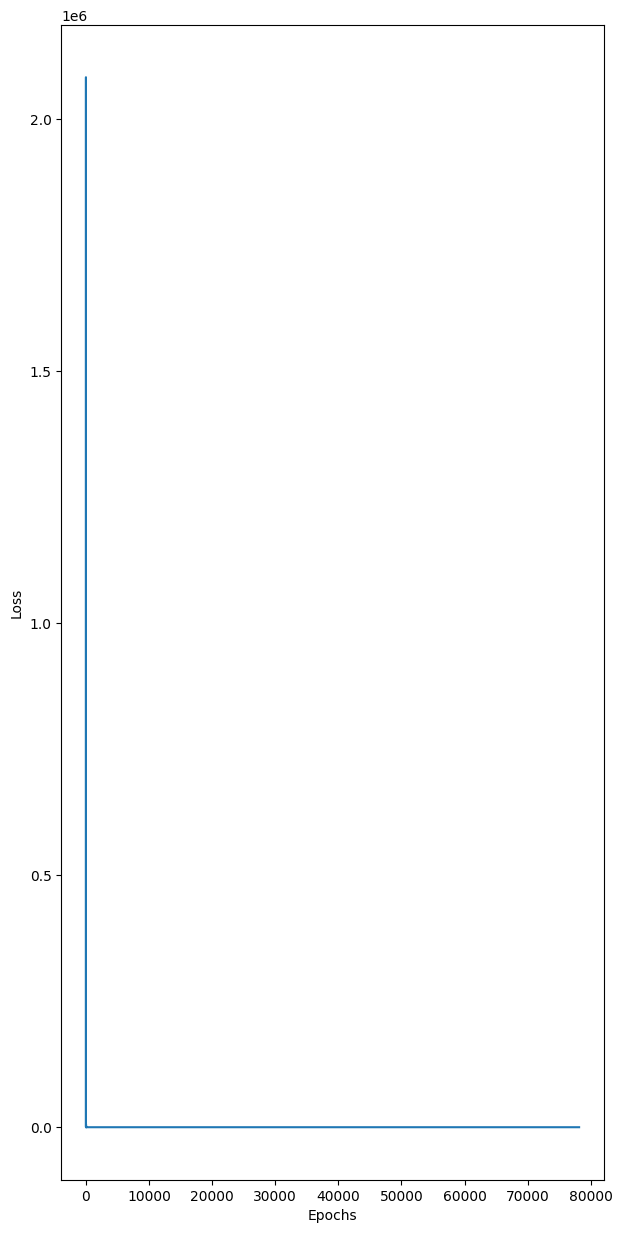

Best threshold for F1: 0.16315621137619019


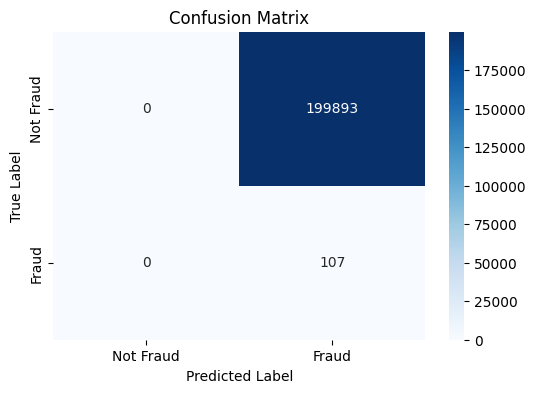

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    199893
           1       0.00      1.00      0.00       107

    accuracy                           0.00    200000
   macro avg       0.50      0.50      0.00    200000
weighted avg       1.00      0.00      0.00    200000



In [5]:
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve

model = NeuralNet().to(device)


class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train.numpy())

weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
losses = []
for epoch in range(1, epochs + 1):
    for X_batch, y_batch in train_dl:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'epoch: {epoch} -> loss: {loss}')
        


plt.figure(figsize=(7, 15))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


model.eval()
with torch.no_grad():
    logits = model(X_test.to(device))
    y_pred_probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
    precisions, recalls, thresholds = precision_recall_curve(y_test.cpu(), y_pred_probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = f1s.argmax()
    best_threshold = thresholds[best_idx]

print(f"Best threshold for F1: {best_threshold}")

preds = (y_pred_probs >= best_threshold).astype(int)


cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, preds, zero_division=True))